### Notebook Description
This notebook is for using the extracted endmembers to perform telluric correction on new observations. The notebook serves as a way to validate extracted components by inspecting how well they can correct telluric lines.  

The notebook is set up to enable correction of multible observations.

If one wishes to perform correction on other spectra then either use the correction function from correction.py or load them into this notebook and run the corrections.

The notebook contains the following steps:
 1. Load packages and observations to correct (either a single observation or multiple observations)
 2. Fit the weights of the autoencoder telluric spectrum to the observations.
 3. Use fitted telluric spectra to perform corrections of the observations and inspect the results.

In [1]:
!nvidia-smi

Wed Apr 17 20:24:32 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:61:00.0 Off |                    0 |
| N/A   37C    P0    47W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:62:00.0 Off |                    0 |
| N/A   

In [2]:
#Importing Packages
from scipy import interpolate
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from scipy.spatial import distance
from scipy import optimize
import pickle
import os
from continuum_normalisation import continuum_normalize
from optimiztion import opt
from optimiztion import opt_O2
from optimiztion import error
import time
from correction import telluric_fit
%matplotlib inline

### 1. Loading Flux and Wave Files
Load them in a way appropriate for the data at hand. The observed flux, wave and blaze files need to be loaded. The wavelength axis must be in units Angstrom (Å) in air in observatory restframe.

If observations are already blaze corrected then no need for the blaze funtion. The blaze corrections are only used for fitting the telluric weights. The output telluric spectra can still be used to correct non-blaze corrected observations.



#### Example of loading single spectrum
Here the validation observation from the paper plots is loaded. 

In [3]:
# Loading Validation observtion
fn  = '../validation_spectrum/HARPN.2020-11-03T10-18-23.184_e2ds_A.fits'
wv  = '../validation_spectrum/HARPN.2020-11-03T07-29-05.596_wave_A.fits'
blz = '../validation_spectrum/HARPN.2020-11-03T07-06-51.587_blaze_A.fits'

# Initializing Arrays
flux_obs_load  = []
wave_obs_load  = []
blaze_obs_load = []
file_name = []
wave_name = []
blaze_name = []

flux, header = fits.getdata(fn, header=True)
wave, header = fits.getdata(wv, header=True)
blaze, header = fits.getdata(blz, header=True)

flux_obs_load.append(flux)
wave_obs_load.append(wave)
blaze_obs_load.append(blaze)      

file_name.append(fn)
wave_name.append(wv)
blaze_name.append(blz)     

flux_obs_load = np.asarray(flux_obs_load)
wave_obs_load = np.asarray(wave_obs_load)
blaze_obs_load = np.asarray(blaze_obs_load)

flux_obs_load=flux_obs_load/blaze_obs_load

In [79]:
# TODO: check if DRS OUTPUT e2ds is already blaze corrected
# https://ftp.eso.org/pub/dfs/pipelines/harps/harps-pipeline-manual-3.0.0.pdf

# Loading Validation observtion
# fits/ADP.2014-09-24T09:43:36.503
fn  = '/home/m.gorsini/telluric-autoencoder/fits/ADP.2014-09-24T09:43:36.503/HARPS.2010-05-21T00:20:03.072_e2ds_A.fits'
wv  = '/home/m.gorsini/telluric-autoencoder/fits/ADP.2014-09-24T09:43:36.503/HARPS.2010-05-20T21:42:21.163_wave_A.fits'
blz = '/home/m.gorsini/telluric-autoencoder/fits/ADP.2014-09-24T09:43:36.503/HARPS.2010-05-20T21:35:20.309_blaze_A.fits' 

# fits/ADP.2018-05-17T01:07:26.787
fn  = '/home/m.gorsini/telluric-autoencoder/fits/ADP.2015-05-21T23:55:33.627/HARPS.2015-05-21T06:17:42.933_e2ds_A.fits'
wv  = '/home/m.gorsini/telluric-autoencoder/fits/ADP.2015-05-21T23:55:33.627/HARPS.2015-05-21T00:41:07.968_wave_A.fits'
blz = '/home/m.gorsini/telluric-autoencoder/fits/ADP.2015-05-21T23:55:33.627/HARPS.2015-05-21T00:35:53.841_blaze_A.fits' 

# fits/ADP.2018-05-17T01:07:26.787
fn  = '/home/m.gorsini/telluric-autoencoder/fits/ADP.2014-09-24T09:43:36.503/HARPS.2010-05-21T00:20:03.072_e2ds_A.fits'
wv  = '/home/m.gorsini/telluric-autoencoder/fits/ADP.2014-09-24T09:43:36.503/HARPS.2010-05-20T21:42:21.163_wave_A.fits'
blz = '/home/m.gorsini/telluric-autoencoder/fits/ADP.2014-09-24T09:43:36.503/HARPS.2010-05-20T21:35:20.309_blaze_A.fits'

In [15]:
entries = ['../solar/ADP.2018-11-10T01:08:51.333/', 
           '../solar/ADP.2018-09-15T01:19:14.928', 
           '../solar/ADP.2018-11-10T01:08:51.355', 
           '../solar/ADP.2018-11-10T01:08:51.395']
# Initializing Arrays
flux_obs_load  = []
wave_obs_load  = []
blaze_obs_load = []
file_name = []
wave_name = []
blaze_name = []
bary_obs_load = []

for entry in entries:
	for path, dirs, files in os.walk(entry):
		for file in files:
			fname = os.path.join(path, file)
			if file.endswith("_e2ds_A.fits"):
				flux, header = fits.getdata(fname, header=True)
				flux_obs_load.append(flux)
				file_name.append(fname)

				bary = header['HIERARCH ESO DRS BERV']
				bary_obs_load.append(bary)
			if file.endswith("_wave_A.fits"):
				wave = fits.getdata(fname)
				wave_obs_load.append(wave)
				wave_name.append(fname)

			if file.endswith("_blaze_A.fits"):

				blaze = fits.getdata(fname)
				blaze_obs_load.append(blaze)
				blaze_name.append(fname)

bary_obs_load = np.array(bary_obs_load)
flux_obs_load = np.array(flux_obs_load)
wave_obs_load = np.array(wave_obs_load)
blaze_obs_load = np.array(blaze_obs_load)

# Using BERV to get same wl as AE_tellurics 
# Light speed in km/s
c = 299792.458
v=-bary_obs_load
wave_obs_load = wave_obs_load * (1.0 + v[:, np.newaxis, np.newaxis] / c)    

# blaze correction
flux_obs_load = flux_obs_load / blaze_obs_load

print('Done Loading')

Done Loading


In [3]:
def load_data(folder, solar=False):
    print('Loading Data...')
    # Initializing Arrays
    flux_obs_load  = []
    wave_obs_load  = []
    blaze_obs_load = []
    file_name = []
    wave_name = []
    blaze_name = []
    bary_obs_load = []

    for path, dirs, files in os.walk(folder):
        for file in files:
            fname = os.path.join(path, file)
            
            if file.endswith("e2ds_A.fits"):
                flux, header = fits.getdata(fname, header=True)
                flux_obs_load.append(flux)
                file_name.append(fname)
                
                bary = header['HIERARCH ESO DRS BERV']
                bary_obs_load.append(bary)
                
            if file.endswith("wave_A.fits"):
                wave = fits.getdata(fname)
                wave_obs_load.append(wave)
                wave_name.append(fname)
                
            if file.endswith("blaze_A.fits"):
                blaze = fits.getdata(fname)
                blaze_obs_load.append(blaze)
                blaze_name.append(fname)
            
    bary_obs_load = np.array(bary_obs_load)
    flux_obs_load = np.array(flux_obs_load)
    wave_obs_load = np.array(wave_obs_load)
    blaze_obs_load = np.array(blaze_obs_load)

    # Using BERV to get same wl as AE_tellurics 
    # Light speed in km/s
    if solar:
        c = 299792.458
        v=-bary_obs_load
        wave_obs_load = wave_obs_load * (1.0 + v[:, np.newaxis, np.newaxis] / c)    

    # blaze correction
    flux_obs_load = flux_obs_load / blaze_obs_load

    print('Done Loading')
    
    return flux_obs_load, wave_obs_load, blaze_obs_load, bary_obs_load, file_name, wave_name, blaze_name

In [10]:
flux_obs_load, wave_obs_load, blaze_obs_load, bary_obs_load, file_name, wave_name, blaze_name = load_data('/projects/data/HARPS/solar/2014', solar=True)

Loading Data...
Done Loading


In [11]:
print(flux_obs_load.shape, wave_obs_load.shape, blaze_obs_load.shape)

(770, 72, 4096) (770, 72, 4096) (770, 72, 4096)


#### Example of loading multiple spectra

In [23]:
## Initializing Arrays
#flux_obs_load  = []
#wave_obs_load  = []
#blaze_obs_load = []
#bary_obs_load = []
#file_name = []
#wave_name = []
#blaze_name = []

#for path, sub, files in os.walk('../validation_spectrum/sun_download_2015'):
#    for name in files:
#        if name.endswith("S2D_A.fits"):
#            fn = path+'/'+name
#            flux = fits.getdata(fn,1) # flux corrected from blaze
#            wave = fits.getdata(fn,5)  # wavelength solution in the air
#            header = fits.getheader(fn)
#            bary = header['HIERARCH TNG QC BERV']
#            flux_obs_load.append(flux)
#            wave_obs_load.append(wave)
#            bary_obs_load.append(bary)
#            file_name.append(fn)

#bary_obs_load = np.asarray(bary_obs_load)
#flux_obs_load = np.asarray(flux_obs_load)
#wave_obs_load = np.asarray(wave_obs_load)

# Using BERV to get same wl as AE_tellurics 
# Light speed in km/s
#c = 299792.458
#v=-bary_obs_load

#for i in range(len(v)):
#    wave_obs_load[i] = wave_obs_load[i] * (1.0 + v[i] / c)    

#print('Done Loading')

### 2. Fitting the telluric spectrum

The telluric_fit function is used to fit the telluric spectrum of the observations. The output is the fitted telluric spectrum along with the weights of the H2O and O2 components.


Input spectra should not be continuum normalized. Input spectra should be blaze corrected.

In [12]:
# HARPS -> 72 orders, from 378-691 nm (89-161)
# HARPS-N -> 69 orders, from 385-691 nm (92-161) (?)
# TAU is trained on HARPS-N solar observation, so we need to cut the HARPS orders to match the HARPS-N orders

flux_obs_load, wave_obs_load, blaze_obs_load = flux_obs_load[:, 3:, :], wave_obs_load[:, 3:, :], blaze_obs_load[:, 3:, :]

In [13]:
telluric_spec,H2O_weights,O2_weights =  telluric_fit(flux_obs_load,wave_obs_load)

Initializing (~ 10 sec)...



/home/m.gorsini/telluric-autoencoder-with-steroids/code/optimiztion.py:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  ntop = trial.suggest_uniform('ntop', 0.1, 4)   # sigma top for continuum normalization
/home/m.gorsini/telluric-autoencoder-with-steroids/code/optimiztion.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  nbins = trial.suggest_uniform('nbins', 0.1, 4) # sigma bottom for continuum normalization
/home/m.gorsini/telluric-autoencoder-with-steroids/code/optimiztion.py:82: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  H2O_weight = trial.suggest_unif

Correcting observation 10/770
Correcting observation 20/770
Correcting observation 30/770
Correcting observation 40/770
Correcting observation 50/770
Correcting observation 60/770
Correcting observation 70/770
Correcting observation 80/770
Correcting observation 90/770
Correcting observation 100/770
Correcting observation 110/770
Correcting observation 120/770
Correcting observation 130/770
Correcting observation 140/770
Correcting observation 150/770
Correcting observation 160/770
Correcting observation 170/770
Correcting observation 180/770
Correcting observation 190/770
Correcting observation 200/770
Correcting observation 210/770
Correcting observation 220/770
Correcting observation 230/770
Correcting observation 240/770
Correcting observation 250/770
Correcting observation 260/770
Correcting observation 270/770
Correcting observation 280/770
Correcting observation 290/770
Correcting observation 300/770
Correcting observation 310/770
Correcting observation 320/770
Correcting observ

### 3. Plot result

Corrections can now be performed by dividing the observed spectra with their corresponding fitted telluric spectra. Here it is shown for the correction of the validation observation:

// *HARPN.2020-11-03T10-18-23.184_e2ds_A.fits*

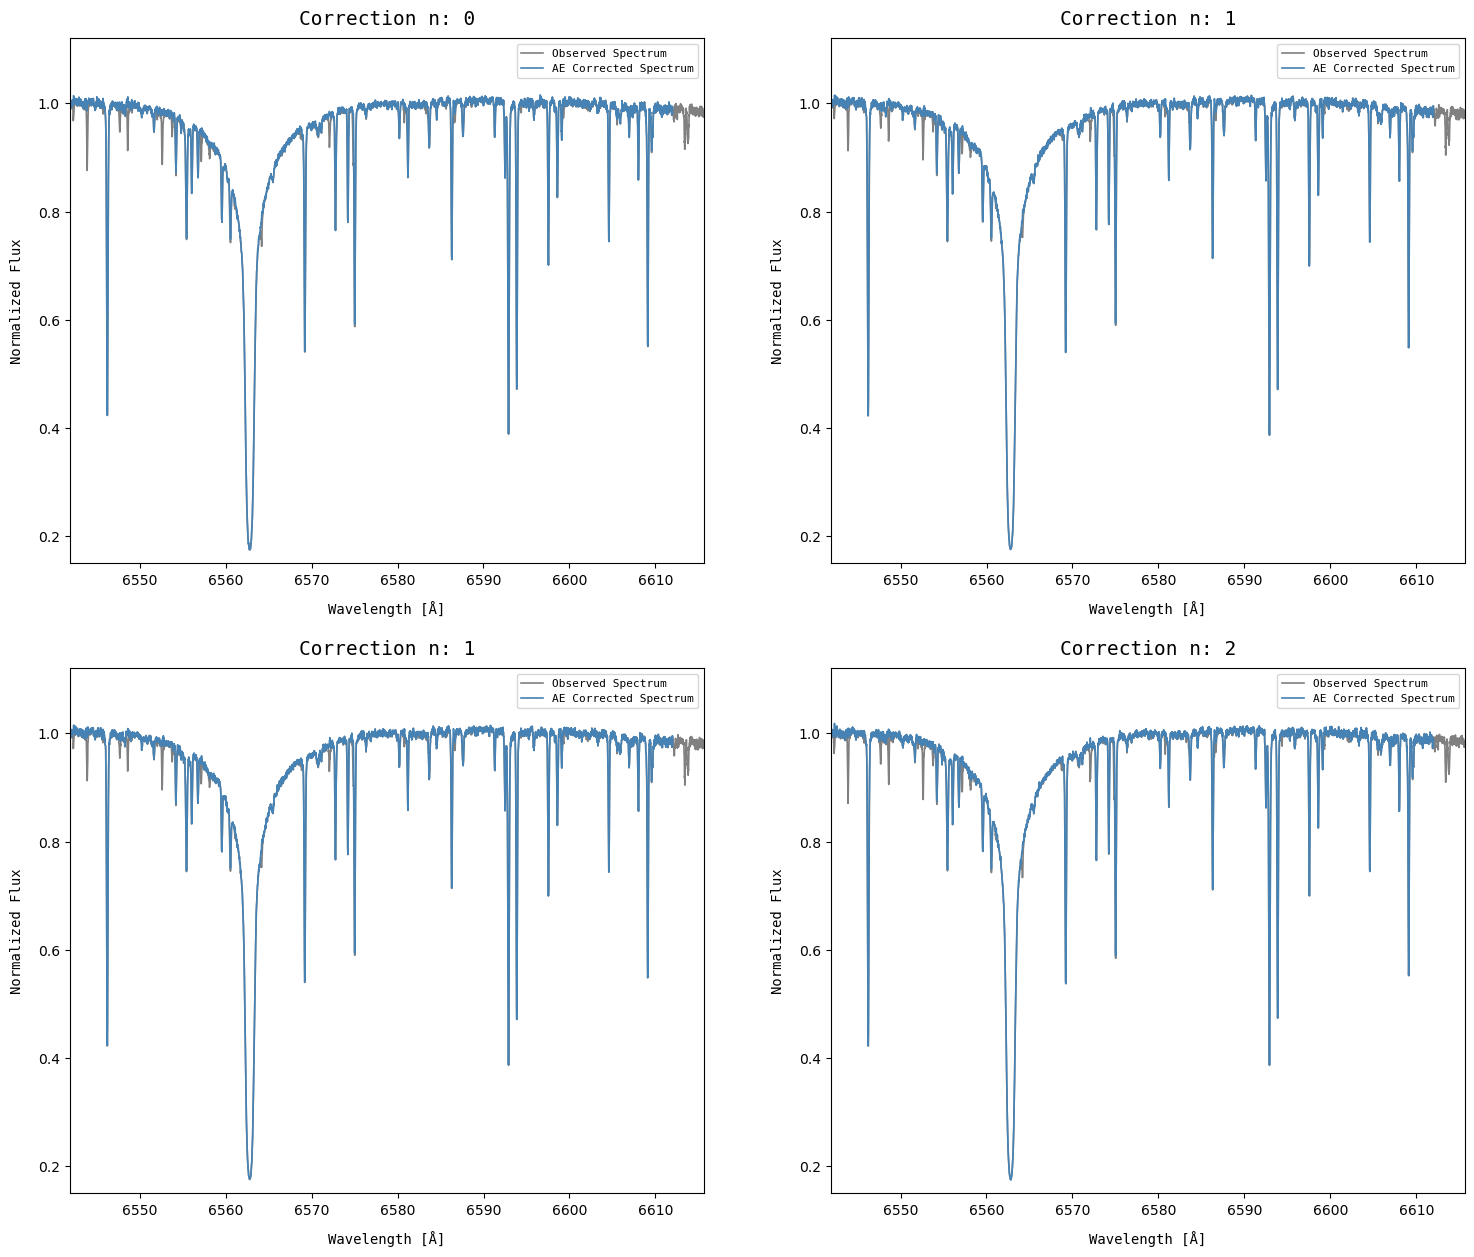

In [8]:
linewidth=1.2
order=64
ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
font = {'fontname':'DejaVu Sans Mono'}
fontsize=10


fig, axs = plt.subplots(2, 2, figsize=(18, 15))

for i in range(2):
	for j in range(2):
		obs = flux_obs_load[i+j,order]
		cont = continuum_normalize(wave_obs_load[i+j,order],obs,n_sigma=[ntop,nbottom])

		axs[i, j].plot(wave_obs_load[i+j,order],obs/cont,color='grey',label='Observed Spectrum',linewidth=linewidth)
		axs[i, j].plot(wave_obs_load[i+j,order],obs/telluric_spec[i+j,order]/cont,color='steelblue',label='AE Corrected Spectrum',linewidth=linewidth)
		# axs[i, j].axis([5880.1,5910.3,0,1.5])
		# if order == 53: axs[i, j].axis([5880.1,5910.3,0,1.5]) # why specific wl range and not ones related to the corresponding wl solution?
		# if order == 64: axs[i, j].axis([6540,6583,0.15,1.12]) # maybe due to some shift (?) during training
		axs[i, j].axis([wave_obs_load[i+j,order][0], wave_obs_load[i+j,order][-1], 0.15, 1.12]) 
		axs[i, j].legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
		axs[i, j].set_xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
		axs[i, j].set_ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
		axs[i, j].set_title(f'Correction n: {i+j}',**font,fontsize=fontsize+4,pad=fontsize)
  
fig.show()

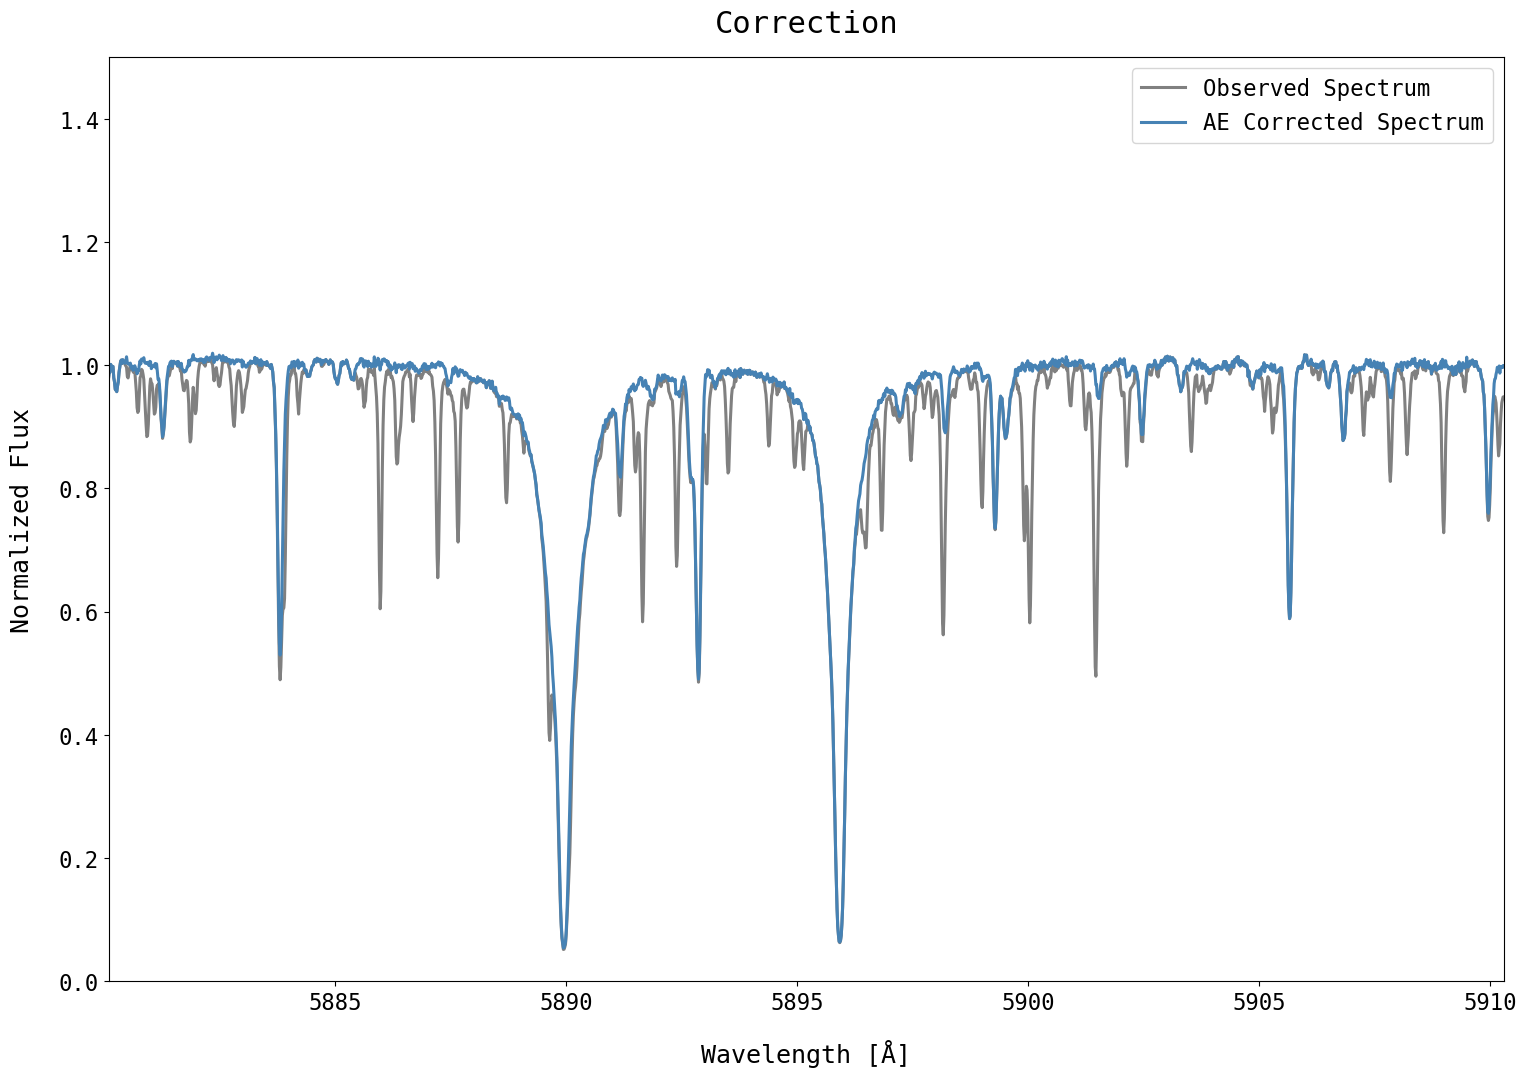

In [13]:
obs_nr=0
order=53
font = {'fontname':'DejaVu Sans Mono'}
plt.figure(figsize=(18,12))
linewidth=2.2

ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
    
obs = flux_obs_load[obs_nr,order] #/ blaze_obs_load[obs_nr,order]
cont = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop,nbottom])
plt.plot(wave_obs_load[obs_nr,order],obs/cont,color='grey',label='Observed Spectrum',linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],obs/telluric_spec[obs_nr,order]/cont,color='steelblue',label='AE Corrected Spectrum',linewidth=linewidth)
plt.axis([5880.1,5910.3,0,1.5]) # 53
# plt.axis([6540,6583,0.15,1.12])  # 64
fontsize=18
plt.legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
plt.xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
plt.title('Correction',**font,fontsize=fontsize+4,pad=fontsize);
plt.xticks(fontsize=fontsize-2,**font);
plt.yticks(fontsize=fontsize-2,**font);

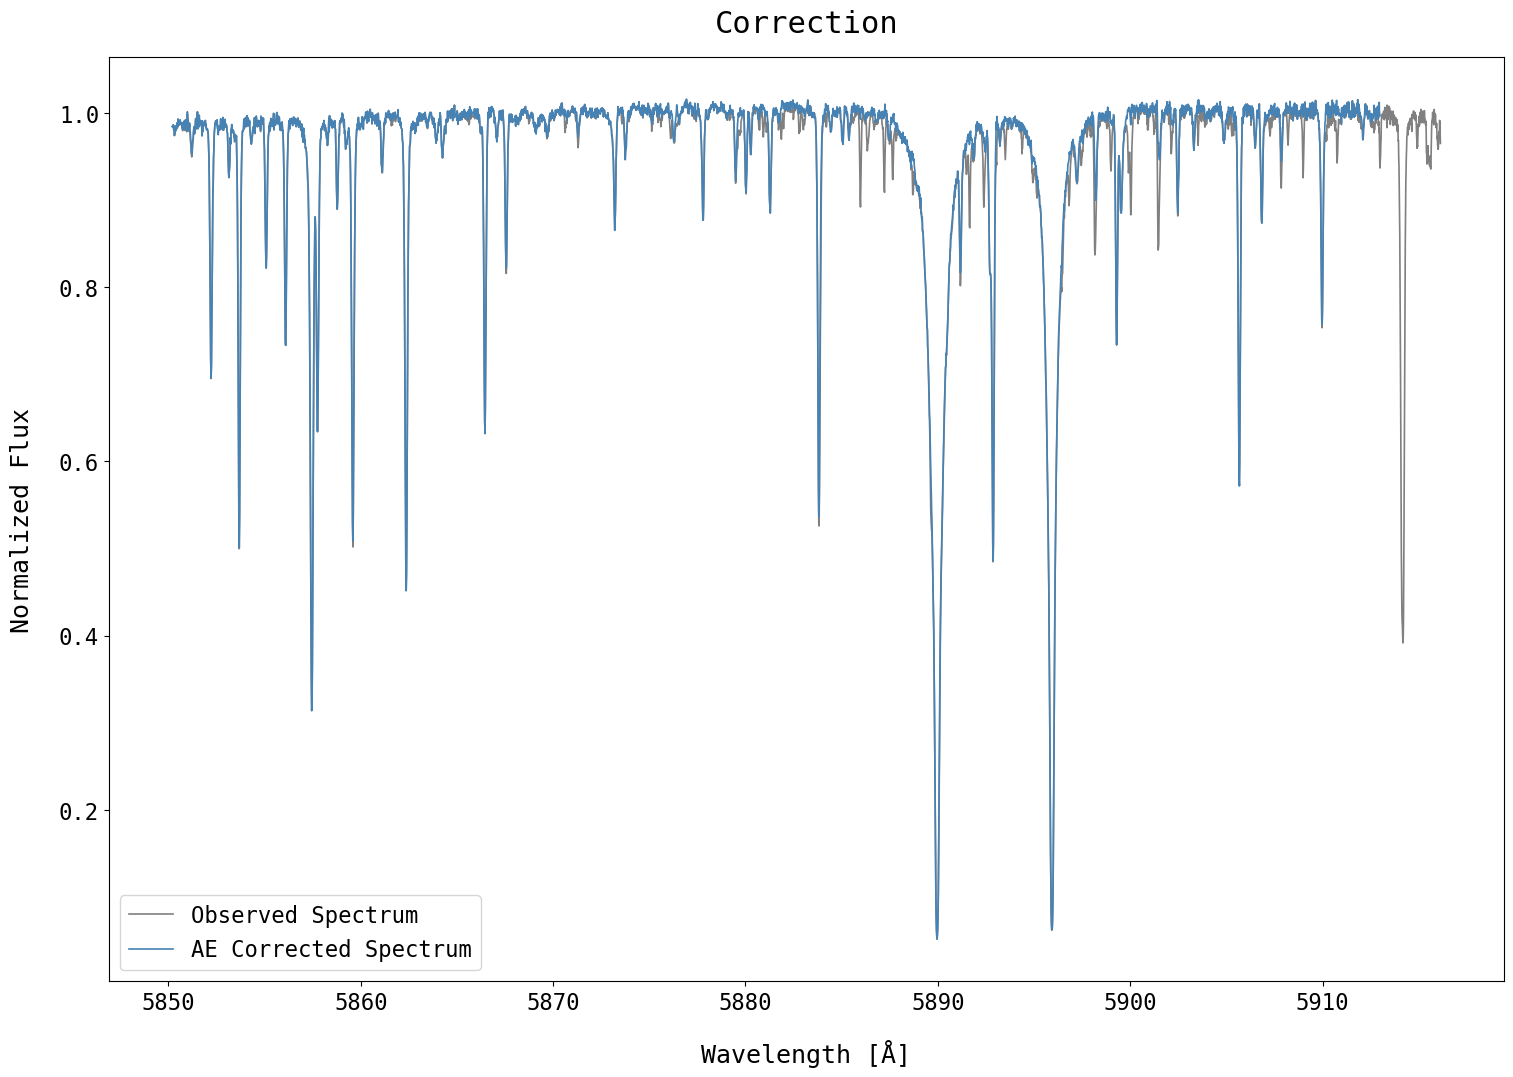

In [10]:
obs_nr=3
order=53
font = {'fontname':'DejaVu Sans Mono'}
plt.figure(figsize=(18,12))
linewidth=1.2

ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
    
obs = flux_obs_load[obs_nr,order] #/ blaze_obs_load[obs_nr,order]
cont = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop,nbottom])
plt.plot(wave_obs_load[obs_nr,order],obs/cont,color='grey',label='Observed Spectrum',linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],obs/telluric_spec[obs_nr,order]/cont,color='steelblue',label='AE Corrected Spectrum',linewidth=linewidth)
# plt.axis([5880.1,5910.3,0,1.5]) # 53
# plt.axis([6540,6583,0.15,1.12])  # 64
fontsize=18
plt.legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
plt.xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
plt.title('Correction',**font,fontsize=fontsize+4,pad=fontsize);
plt.xticks(fontsize=fontsize-2,**font);
plt.yticks(fontsize=fontsize-2,**font);

### Molecfit 

Loading a full Molecfit correction of the validation observation to compare. 

A molecfit correction has only been computed for the validation observation:

*HARPN.2020-11-03T10-18-23.184_e2ds_A.fits*

so the comparison here does not work if other spectra are corrected.

In [35]:
# from 1d version
output = fits.getdata('../molecfit/solar_h2o_o2_5_g3p0l1p5_v0_k300_wl2_cont3_box0_tac.fits')

wl = output['lambda'] # original vacuum wl
fl = output['flux'] # original flux
cfl = output['cflux'] # corrected flux
wl_tel = output['mlambda'] # model telluric wl
trans_tel = output['mtrans'] # model telluric transmission spectrum

# Vac2Air conversion
def vac2air(wl_vac):
    """
    Convert wl from vacuum to air
 
    Parameters
    ----------
    wl_vac : array
        wl in vacuum, in Å.
 
    Returns
    -------
    wl_air : array
        wl in air, in Å.
 
    """
    sigma2 = (1E4/wl_vac)**2
    fact = 1 + 5.792105E-2/(238.0185 - sigma2) + 1.67917E-3/(57.362 - sigma2)
    wl_air = wl_vac * (1/fact)
    return wl_air
                                                                  
                                                                  
# Converting molect from vacuum to air
mol_wave=vac2air(wl*10000)  
mol_combined = trans_tel

wave_obs = wave_obs_load[0]
n_apertures = flux_obs_load.shape[1] # Number of apertures in training data
P = flux_obs_load.shape[2] # Pixels in each aperture

# Interpolating molecfitspectra to observed spectrum in each aperture
mol_interpolated = np.zeros([n_apertures,P])
for i in range(0,n_apertures): 
    f = interpolate.interp1d(mol_wave, mol_combined,bounds_error=False,fill_value=np.nan,kind='quadratic')
    mol_interpolated[i]  = f(wave_obs[i])

### Plotting the comparison

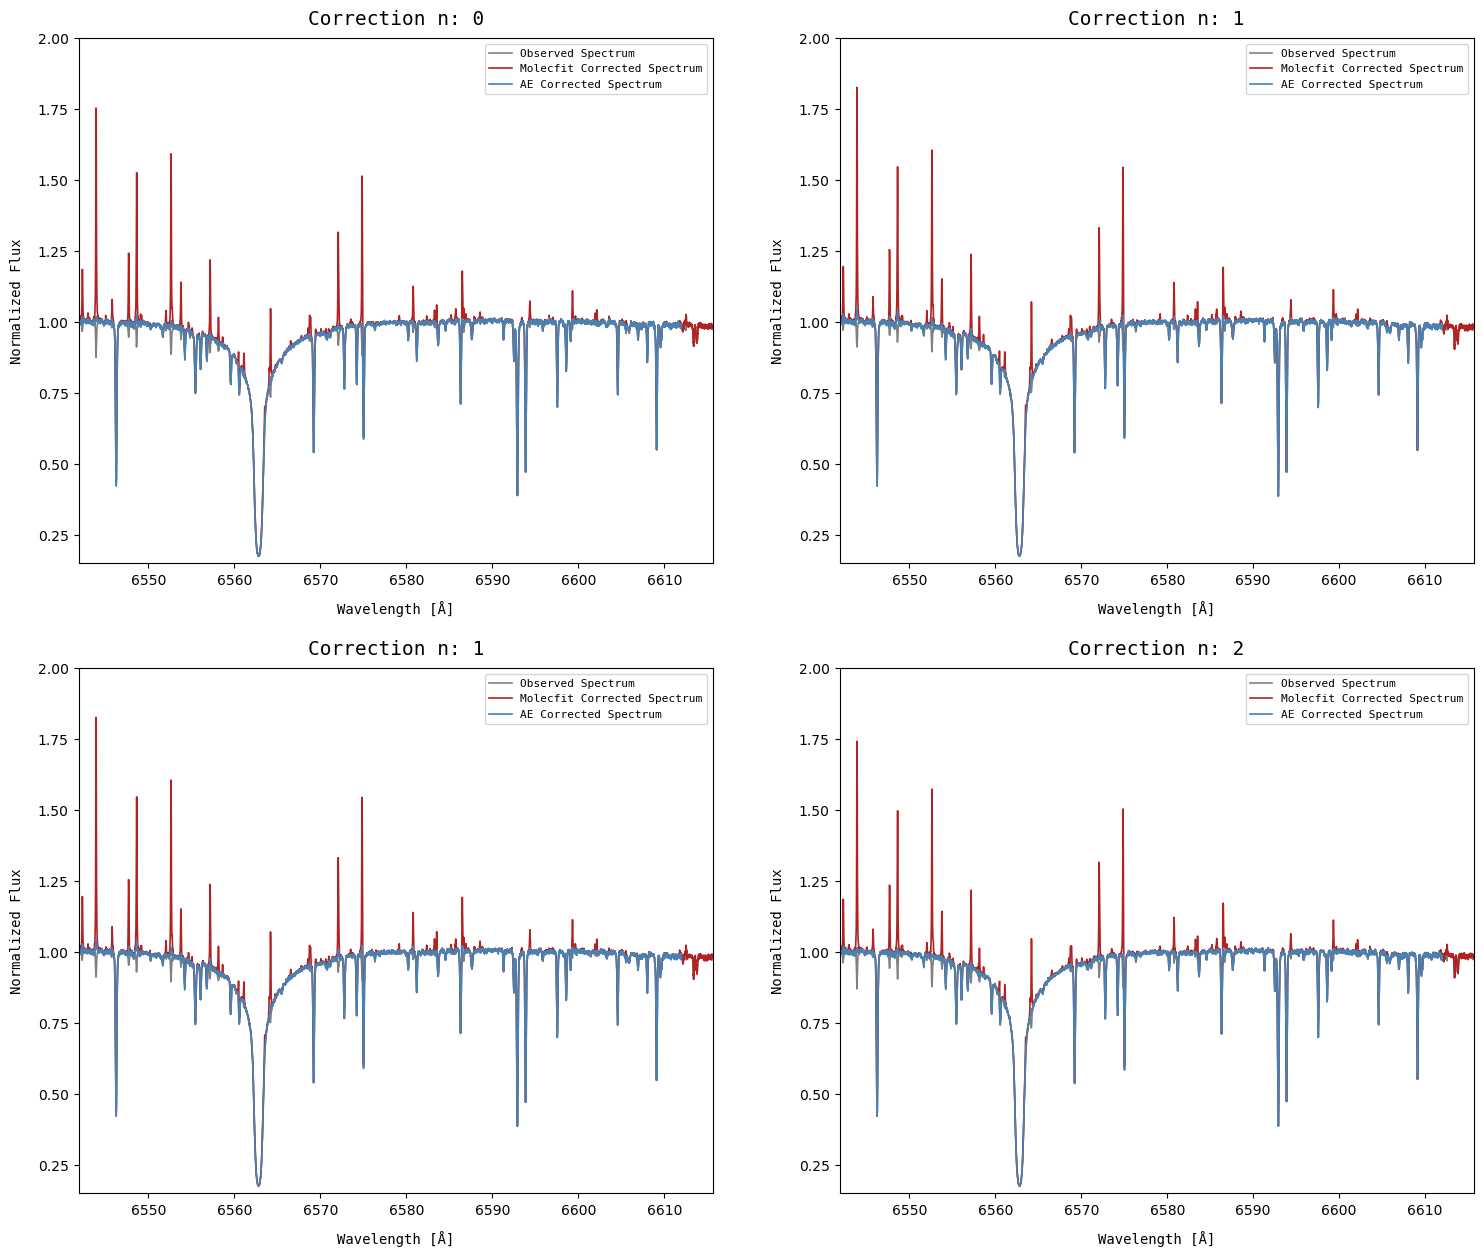

In [20]:
linewidth=1.2
obs_nr = 3
order=64
ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
font = {'fontname':'DejaVu Sans Mono'}
fontsize=10


fig, axs = plt.subplots(2, 2, figsize=(18, 15))

for i in range(2):
	for j in range(2):
		obs = flux_obs_load[i+j,order]
		cont = continuum_normalize(wave_obs_load[i+j,order],obs,n_sigma=[ntop,nbottom])

		axs[i, j].plot(wave_obs_load[i+j,order],obs/cont,color='grey',label='Observed Spectrum',linewidth=linewidth)
		axs[i, j].plot(wave_obs_load[i+j,order],obs/mol_interpolated[order]/cont,color='firebrick',label='Molecfit Corrected Spectrum',linewidth=linewidth)
		axs[i, j].plot(wave_obs_load[obs_nr,order],obs/telluric_spec[obs_nr,order]/cont,color='steelblue',label='AE Corrected Spectrum',linewidth=linewidth)
		if order == 53: axs[i, j].axis([5880.1,5910.3,0,1.5])
		# if order == 64: axs[i, j].axis([6540,6583,0.15,1.12])
		if order == 64: axs[i, j].axis([wave_obs_load[obs_nr,order][0], wave_obs_load[obs_nr,order][-1], 0.15, 2.0])
		axs[i, j].legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
		axs[i, j].set_xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
		axs[i, j].set_ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
		axs[i, j].set_title(f'Correction n: {i+j}',**font,fontsize=fontsize+4,pad=fontsize)
  
fig.show()

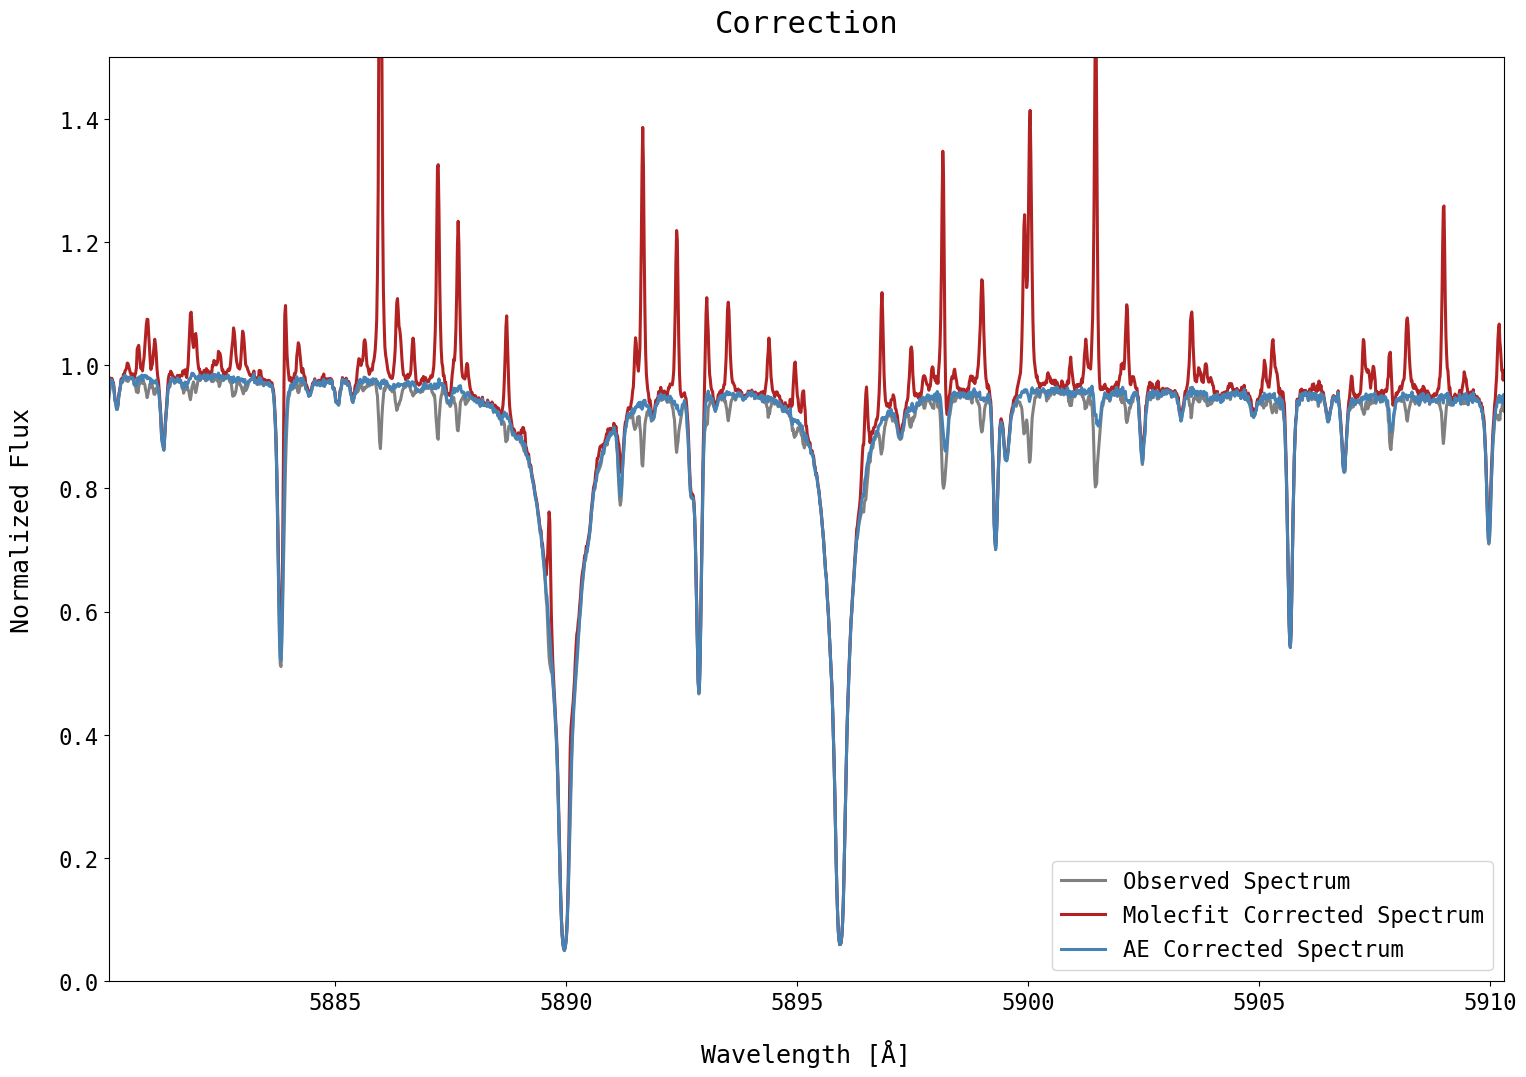

In [21]:
# Select observation and aperture (order) to show comparison for. 
obs_nr=3
order=53 # Check for example aperture 53 or 64 for strong H2O tellurics.

font = {'fontname':'DejaVu Sans Mono'}
plt.figure(figsize=(18,12))
linewidth=2.2
cont = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop,nbottom])
obs = flux_obs_load[obs_nr,order]#/blaze_obs_load[obs_nr,order]

plt.plot(wave_obs_load[obs_nr,order],obs/cont,color='grey',label='Observed Spectrum',linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],obs/mol_interpolated[order]/cont,color='firebrick',label='Molecfit Corrected Spectrum',linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],obs/telluric_spec[obs_nr,order]/cont,color='steelblue',label='AE Corrected Spectrum',linewidth=linewidth)

if order ==53:
    plt.axis([5880.1,5910.3,0,1.5]) # 53
    
if order == 64:
    plt.axis([6540,6583,0.15,1.12])  # 64
    
fontsize=18
plt.legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
plt.xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
plt.title('Correction',**font,fontsize=fontsize+4,pad=fontsize);
plt.xticks(fontsize=fontsize-2,**font);
plt.yticks(fontsize=fontsize-2,**font);

### Computing the RMSE of the residual

In [22]:
# check for NaNs
# RMSE of the residual wrt AE telluric (we get nans from the division by zero)

print(np.all(np.isfinite(obs)))
print(np.all(np.isfinite(telluric_spec[obs_nr,order]))) # ae telluric gets nans (?)
print(np.all(np.isfinite(cont)))
print(np.all(np.isfinite(mol_interpolated[order])))
print(np.all(np.isfinite(obs/telluric_spec[obs_nr,order]/cont)))


True
False
True
True
False


In [23]:
np.where(np.isnan(telluric_spec[obs_nr,order]))[0]

array([3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875,
       3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886,
       3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897,
       3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908,
       3909, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919,
       3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930,
       3931, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940, 3941,
       3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952,
       3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963,
       3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974,
       3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985,
       3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996,
       3997, 3998, 3999, 4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007,
       4008, 4009, 4010, 4011, 4012, 4013, 4014, 40

In [24]:
# obs = flux_obs_load[obs_nr,order] #/blaze_obs_load[obs_nr,order]
# cont = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop,nbottom])

# order is fixed above, same for obs_nr
# RMSE of the residual wrt molecfit
np.sqrt(np.mean(((flux_obs_load[obs_nr,order] / cont) - (flux_obs_load[obs_nr,order] / mol_interpolated[order] / cont)) ** 2))

0.06958814679866988

In [25]:
# telluric spec (output of AE) contains NaNs, probably due to interpolation fill value equal to NaNs 
# for handling this, we use np.nanmean instead of np.mean

# order is fixed above, same for obs_nr
np.sqrt(np.nanmean(((flux_obs_load[obs_nr,order] / cont) - (flux_obs_load[obs_nr,order] / telluric_spec[obs_nr, order] / cont)) ** 2))


0.012415118134605928

In [26]:
# compute the average RMSE of the residual (AE) for all the observations, given an order
order = 64
np.mean([np.sqrt(np.mean(((flux_obs_load[i,order] / cont) - (flux_obs_load[i,order] / mol_interpolated[order] / cont)) ** 2)) for i in range(flux_obs_load.shape[0])]) 

0.04848795412900307

In [27]:
# compute the average RMSE of the residual (AE) for all the observations, given an order
order = 64

np.mean([np.sqrt(np.nanmean(((flux_obs_load[i,order] / cont) - (flux_obs_load[i,order] / telluric_spec[i, order] / cont)) ** 2)) for i in range(flux_obs_load.shape[0])])

0.008666562397406204

## Visualizing the plot of each order, given an observation

In [ ]:
from pathlib import Path

if not Path('../plots').exists():
    Path('../plots').mkdir(parents=True, exist_ok=True)

linewidth=1.2
obs_nr = 3
order=64
ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
font = {'fontname':'DejaVu Sans Mono'}
fontsize=10

for order in range(flux_obs_load.shape[1]):
	fig, axs = plt.subplots(2, 2, figsize=(18, 15))

	for i in range(2):
		for j in range(2):
			obs = flux_obs_load[i+j,order]
			cont = continuum_normalize(wave_obs_load[i+j,order],obs,n_sigma=[ntop,nbottom])

			axs[i, j].plot(wave_obs_load[i+j,order],obs/cont,color='grey',label='Observed Spectrum',linewidth=linewidth)
			axs[i, j].plot(wave_obs_load[i+j,order],obs/mol_interpolated[order]/cont,color='firebrick',label='Molecfit Corrected Spectrum',linewidth=linewidth)
			axs[i, j].plot(wave_obs_load[obs_nr,order],obs/telluric_spec[obs_nr,order]/cont,color='steelblue',label='AE Corrected Spectrum',linewidth=linewidth)
			# if order == 53: axs[i, j].axis([5880.1,5910.3,0,1.5])
			# if order == 64: axs[i, j].axis([6540,6583,0.15,1.12])
			# if order == 64: axs[i, j].axis([wave_obs_load[obs_nr,order][0], wave_obs_load[obs_nr,order][-1], 0.15, 2.0])
			axs[i, j].legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
			axs[i, j].set_xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
			axs[i, j].set_ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
			axs[i, j].set_title(f'Correction n: {i+j}',**font,fontsize=fontsize+4,pad=fontsize)
	
	fig.savefig(f'../plots/order_{order}.png')	
	plt.close(fig)
	

In [39]:
from pathlib import Path

if not Path('../plots').exists():
    Path('../plots').mkdir(parents=True, exist_ok=True)

linewidth=1.0
obs_nr = 0
ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
font = {'fontname':'DejaVu Sans Mono'}
fontsize=10

for order in range(flux_obs_load.shape[1]):
	fig, axs = plt.subplots(figsize=(20, 6))

	for i in range(1):
		for j in range(1):
			obs = flux_obs_load[i+j,order]
			cont = continuum_normalize(wave_obs_load[i+j,order],obs,n_sigma=[ntop,nbottom])

			axs.plot(wave_obs_load[i+j,order],obs/cont,color='grey',label='Observed Spectrum',linewidth=linewidth)
			axs.plot(wave_obs_load[i+j,order],obs/mol_interpolated[order]/cont,color='firebrick',label='Molecfit Corrected Spectrum',linewidth=linewidth)
			axs.plot(wave_obs_load[obs_nr,order],obs/telluric_spec[obs_nr,order]/cont,color='steelblue',label='AE Corrected Spectrum',linewidth=linewidth)
			# if order == 53: axs[i, j].axis([5880.1,5910.3,0,1.5])
			# if order == 64: axs[i, j].axis([6540,6583,0.15,1.12])
			# if order == 64: axs[i, j].axis([wave_obs_load[obs_nr,order][0], wave_obs_load[obs_nr,order][-1], 0.15, 2.0])
			axs.legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
			axs.set_xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
			axs.set_ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
			axs.set_title(f'Correction n: {i+j}',**font,fontsize=fontsize+4,pad=fontsize)
	
	fig.savefig(f'../plots/order_{order}.png', dpi=400)	
	plt.close(fig)